In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
# from sklearn.utils.class_weight import compute_class_weight
# from scikeras.wrappers import KerasClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from newsapi import NewsApiClient
import string
import spacy
from sklearn.utils import resample

### Project
- Project group. Adam and Roger
- SIN wants a model that can be used to see if the title of an article can determine if it is fake information.
- Classify text, 1 = Fake 0 = Real

### Read csv files

In [144]:
data = pd.read_csv("csv_file/big_data.csv") 
test_data = pd.read_csv("csv_file/test_data.csv")

In [145]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download spaCy model
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [146]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [147]:
# Extract texts and labels
texts = data["headlines"]
labels = data["outcome"]

In [148]:
# Preprocessing
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Tokenization using spaCy
    tokens = nlp(text)
    tokens = [token.text for token in tokens]
    
    # Punctuation Removal
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens


# Apply preprocessing to all texts

def preprocess_and_undersample(X, y):
    # Apply text preprocessing to your text data
    preprocessed_texts = [preprocess_text(text) for text in X]

    # Combine preprocessed text and labels for undersampling
    preprocessed_data = pd.DataFrame({'headlines': preprocessed_texts, 'outcome': y})

    # Separate majority and minority classes
    majority_class = preprocessed_data[preprocessed_data['outcome'] == 1]
    minority_class = preprocessed_data[preprocessed_data['outcome'] == 0]

    # Undersample the majority class
    majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)
    
    # Combine minority class and undersampled majority class
    undersampled_data = pd.concat([majority_undersampled, minority_class])
    
    # Separate features and labels after undersampling
    X_undersampled = undersampled_data['headlines']
    y_undersampled = undersampled_data['outcome']

    print(y_undersampled.value_counts())

    return X_undersampled, y_undersampled

X_train_undersampled, y_train_undersampled = preprocess_and_undersample(texts, labels)




# Tokenization using Keras Tokenizer
max_words = 27458
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_undersampled)
sequences = tokenizer.texts_to_sequences(X_train_undersampled)

# Padding sequences
maxlen = 75
X = pad_sequences(sequences, maxlen=maxlen)

# Convert labels to numpy array
y = np.array(y_train_undersampled)

outcome
1    8719
0    8719
Name: count, dtype: int64


In [149]:
# Build the RNN model
embedding_dim = 50  # Dimensionality of the embedding space
hidden_units = 50  # Number of LSTM units

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Train the model
epochs = 5
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/5
349/349 [==============================] - 17s 42ms/step - loss: 0.3632 - accuracy: 0.8424 - val_loss: 0.2351 - val_accuracy: 0.9054
Epoch 2/5
349/349 [==============================] - 14s 40ms/step - loss: 0.1279 - accuracy: 0.9550 - val_loss: 0.2219 - val_accuracy: 0.9165
Epoch 3/5
349/349 [==============================] - 14s 40ms/step - loss: 0.1079 - accuracy: 0.9634 - val_loss: 0.2511 - val_accuracy: 0.8943
Epoch 4/5
349/349 [==============================] - 14s 40ms/step - loss: 0.0668 - accuracy: 0.9785 - val_loss: 0.2571 - val_accuracy: 0.9082
Epoch 5/5
109/109 [==============================] - 1s 11ms/step - loss: 0.3197 - accuracy: 0.9008
Test Accuracy: 90.08%


109/109 [==============================] - 1s 10ms/step


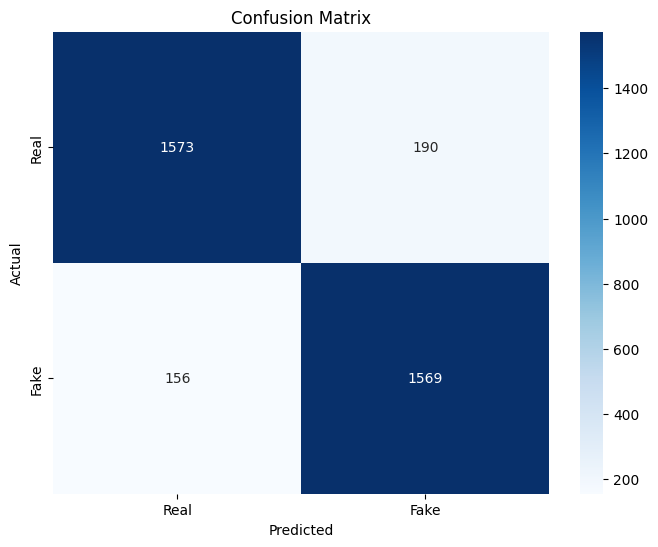

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1763
           1       0.89      0.91      0.90      1725

    accuracy                           0.90      3488
   macro avg       0.90      0.90      0.90      3488
weighted avg       0.90      0.90      0.90      3488



In [150]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

In [151]:
newsapi = NewsApiClient(api_key='2ec72918ca08491b885785649a92cfb7')
covid_articles = newsapi.get_everything(q='covid',
                                        language='en',
                                        sort_by='relevancy',
                                        page=1)

clean_title = []
for index, i in enumerate(covid_articles['articles']):
    row = i['title']
    row = row.split(" ")
    row = ' '.join(letter for letter in row if letter.isalnum() or letter == "COVID-19")
    if "COVID-19" in row:
        row = row.replace("COVID-19", "COVID19")
    row = row.lower()
    clean_title.append(row)

In [152]:
# if testing with newsapi
# X = clean_title
# obs! can not evaluate with y

In [153]:
X = test_data["headlines"]
y = test_data["outcome"]

In [154]:
test_data.head()

,headlines,outcome
0,CDC has given more than $200M to address #COVI...,0
1,#IndiaFightsCorona TEST TRACK TREAT- effective...,0
2,"Ireland's entire cabinet will ""restrict their ...",0
3,The Chairman of the Republican Party of Texas ...,1
4,Iranians have published a report saying that c...,1


In [155]:
preprocessed_title = [preprocess_text(text) for text in X]

In [156]:
new_sequences = tokenizer.texts_to_sequences(preprocessed_title)
new_padded_sequence = pad_sequences(new_sequences, maxlen=maxlen)

In [157]:
predictions = model.predict(new_padded_sequence)

7/7 [==============================] - 0s 10ms/step


In [158]:
threshold = 0.5

In [159]:
binary_predictions = (predictions >= threshold).astype(int)

In [160]:
for index, title in enumerate(X):
    prediction = binary_predictions[index]
    if prediction == 1:
        prediction = "Fake"
    else:
        prediction = "Real"
    print(f"Title: {title}")
    print(f"Prediction: {prediction}")
    print("=" * 50)

Title: CDC has given more than $200M to address #COVID19 health disparities among American Indian &amp; Alaska Native people who have suffered a disproportionate burden of illness. Funding will broaden access to COVID-19 resources across tribal communities. https://t.co/MG8e5TWigl https://t.co/KwoPLuxG4g
Prediction: Real
Title: #IndiaFightsCorona TEST TRACK TREAT- effective implementation by the Centre and States/UTs has ensured that India has one of lowest #COVID19 cases and deaths per million population compared to several other countries. https://t.co/Caqhv0M0rK
Prediction: Real
Title: Ireland's entire cabinet will "restrict their movements" after the health minister felt unwell and was tested for #coronavirus it has been reported https://t.co/i5zO9bFugY
Prediction: Fake
Title: The Chairman of the Republican Party of Texas said the recovery rate for COVID-19 is 99.9% in Texas. That’s False. @PolitiFactTexas https://t.co/GmUXoVT2Dh https://t.co/ltIHWPchJM
Prediction: Real
Title: Iran

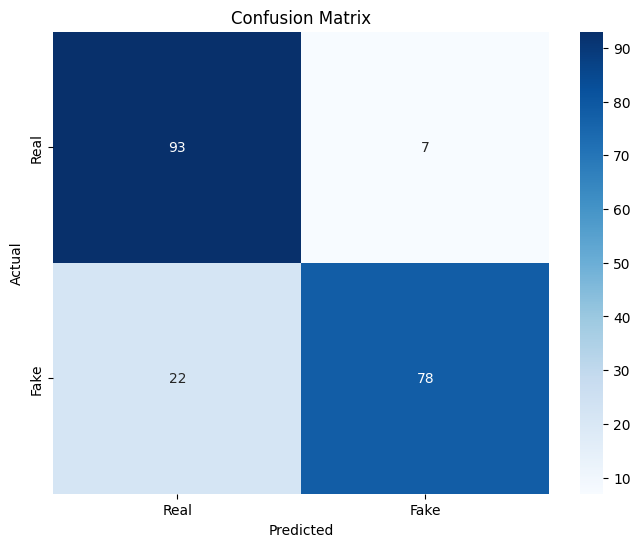

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87       100
           1       0.92      0.78      0.84       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



In [161]:
cm = confusion_matrix(y, binary_predictions)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y, binary_predictions))